In [1]:
from models import *
from train import *
from plot import *
from utils import *
from explore import *
import matplotlib.pyplot as plt


# Manual model testing

In [2]:
# Import dataset
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(
    1000)


In [3]:
# Ethan

model_builder = Siamese
model_params = {
    'fc_parameters': {'input_size': 64}
}
model = model_builder(**model_params)


In [4]:
# Raphael

model_builder = BaseLineNet
model_params = {}
model = model_builder(**model_params)

model_builder = SiameseConvNet1
model_params = {}
model = model_builder(**model_params)

model_builder = SiameseConvNet2
model_params = {}
model = model_builder(**model_params)


In [5]:
# Kathleen
# Specify one_hot_classes=True, one_hot_leq=True

model_builder = SiameseNN
model_params = {}
model = model_builder(**model_params)

model_builder = SiameseNNAll
model_params = {}
model = model_builder(**model_params)

model_builder = Siamese2
model_params = {}
model = model_builder(**model_params)

model_builder = SiameseAll
model_params = {}
model = model_builder(**model_params)


In [6]:
device = torch.device('cpu')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

show_values = False

_train_input = train_input[0:5]
_train_target = train_target[0:5]
_train_classes = train_classes[0:5]

one_hot_classes = True
one_hot_leq = False
_data_input, _data_target, _data_classes = \
    preprocess_dataset(_train_input, _train_target, _train_classes,
                       one_hot_classes=one_hot_classes, one_hot_leq=one_hot_leq,
                       device=device)

print(f'train input: size={_train_input.size()}, dtype={_train_input.dtype}')
print(
    f'train target: size={_train_target.size()}, dtype={_train_target.dtype}')
print(
    f'train classes: size={_train_classes.size()}, dtype={_train_classes.dtype}')

print()
print(f'data input: size={_data_input.size()}, dtype={_data_input.dtype}')
print(f'data target: size={_data_target.size()}, dtype={_data_target.dtype}')
print(
    f'data classes: size={_data_classes.size()}, dtype={_data_classes.dtype}')

with torch.no_grad():
    pred_leq, (pred_class0, pred_class1) = model(_data_input)
    print()
    if pred_leq is not None:
        print(
            f'Less or equal output: size={pred_leq.size()}, dtype={pred_leq.dtype}')
        if show_values:
            print(pred_leq)
    if pred_class0 is not None:
        print(
            f'Class0 output: size={pred_class0.size()}, dtype={pred_class0.dtype}{pred_class0 if show_values else ""}')
        if show_values:
            print(pred_class0)
    if pred_class1 is not None:
        print(
            f'Class1 output: size={pred_class1.size()}, dtype={pred_class1.dtype}{pred_class1 if show_values else ""}')
        if show_values:
            print(pred_class1)


out_leq, (out_class0, out_class1) = output_to_predictions(pred_leq, pred_class0,
                                                          pred_class1, one_hot_classes=one_hot_classes, one_hot_leq=one_hot_leq)
print()
if out_leq is not None:
    print(
        f'Less or equal prediction: size={out_leq.size()}, dtype={out_leq.dtype}')
    if show_values:
        print(out_leq)
if out_class0 is not None:
    print(
        f'Class0 prediction: size={out_class0.size()}, dtype={out_class0.dtype}{out_class0 if show_values else ""}')
    if show_values:
        print(out_class0)
if out_class1 is not None:
    print(
        f'Class1 prediction: size={out_class1.size()}, dtype={out_class1.dtype}{out_class1 if show_values else ""}')
    if show_values:
        print(out_class1)

if show_values:
    print()
    print(f'target:\n{_train_target}')
    print(f'classes:\n{_train_classes}')

acc_classes = ((out_class0 == _train_classes[:, 0]) & (
    out_class1 == _train_classes[:, 1])).float().mean().item()
print()
print(f'Accuracy classes: {acc_classes}')


train input: size=torch.Size([5, 2, 14, 14]), dtype=torch.float32
train target: size=torch.Size([5]), dtype=torch.int64
train classes: size=torch.Size([5, 2]), dtype=torch.int64

data input: size=torch.Size([5, 2, 14, 14]), dtype=torch.float32
data target: size=torch.Size([5, 1]), dtype=torch.float32
data classes: size=torch.Size([5, 2, 10]), dtype=torch.float32

Class0 output: size=torch.Size([5, 10]), dtype=torch.float32
Class1 output: size=torch.Size([5, 10]), dtype=torch.float32

Class0 prediction: size=torch.Size([5]), dtype=torch.int64
Class1 prediction: size=torch.Size([5]), dtype=torch.int64

Accuracy classes: 0.0


In [7]:
# Model parameters
summary(model, input_size=(1, 2, 14, 14))


Layer (type:depth-idx)                   Output Shape              Param #
SiameseAll                               --                        --
├─Conv2d: 1-1                            [1, 32, 12, 12]           320
├─Conv2d: 1-2                            [1, 64, 10, 10]           18,496
├─Linear: 1-3                            [1, 256]                  409,856
├─Linear: 1-4                            [1, 10]                   2,570
├─Conv2d: 1-5                            [1, 32, 12, 12]           (recursive)
├─Conv2d: 1-6                            [1, 64, 10, 10]           (recursive)
├─Linear: 1-7                            [1, 256]                  (recursive)
├─Linear: 1-8                            [1, 10]                   (recursive)
Total params: 431,242
Trainable params: 431,242
Non-trainable params: 0
Total mult-adds (M): 4.62
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 1.72
Estimated Total Size (MB): 1.82

## Single cycle testing

In [8]:
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

start = time.perf_counter()
info_cycle = train_model(model,
                         train_input, train_target, train_classes,
                         nb_epochs=100, mini_batch_size=100,
                         criterion_classes=nn.CrossEntropyLoss(), criterion_classes_params={'input': 'pred_class{i}', 'target': 'data_classes{i}'},
                         criterion_leq=nn.BCELoss(), criterion_leq_params={'input': 'pred_leq', 'target': 'data_target'},
                         optimizer=torch.optim.SGD(
                             model.parameters(), lr=4e-3),
                         weight_loss_classes=0.5, weight_loss_leq=0.5,
                         freeze_epochs=0,
                         one_hot_classes=True, one_hot_leq=False,
                         verbose=False,
                         test_input=test_input, test_target=test_target, test_classes=test_classes,
                         unsqueeze_leq=True,
                         device=device)
end = time.perf_counter()
print(f'Time: {end - start:.2f}s')


Time: 2.45s


In [9]:
with torch.no_grad():
    # pred_leq, (pred_class0, pred_class1) = model(train_input)
    pred_leq, (pred_class0, pred_class1) = compute_predictions(model, train_input.to(device),
                                                               one_hot_classes=one_hot_classes, one_hot_leq=one_hot_leq)

    # print(pred_leq.size(), train_target.size())
    if pred_leq is not None:
        acc_leq = (pred_leq == train_target.unsqueeze(
            1).to(device)).float().mean().item()
        print(f'Accuracy on the training set: {acc_leq:.4f}')
    print(classification_report(train_classes[:, 0], pred_class0.cpu(
    ), target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))
    print(classification_report(train_classes[:, 1], pred_class1.cpu(
    ), target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       107
           1       0.93      1.00      0.96       105
           2       0.64      0.99      0.78       106
           3       0.73      1.00      0.85        90
           4       0.95      1.00      0.97        94
           5       0.74      0.99      0.84        96
           6       0.71      1.00      0.83        98
           7       0.93      0.98      0.96       101
           8       0.00      0.00      0.00       105
           9       0.73      0.95      0.83        98

    accuracy                           0.78      1000
   macro avg       0.64      0.79      0.70      1000
weighted avg       0.63      0.78      0.69      1000

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.92      0.99      0.95        94
           2       0.63      0.97      0.77       107
           3       0.75 

/home/ethan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ethan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ethan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ethan/.local/lib/python3.10/site-p

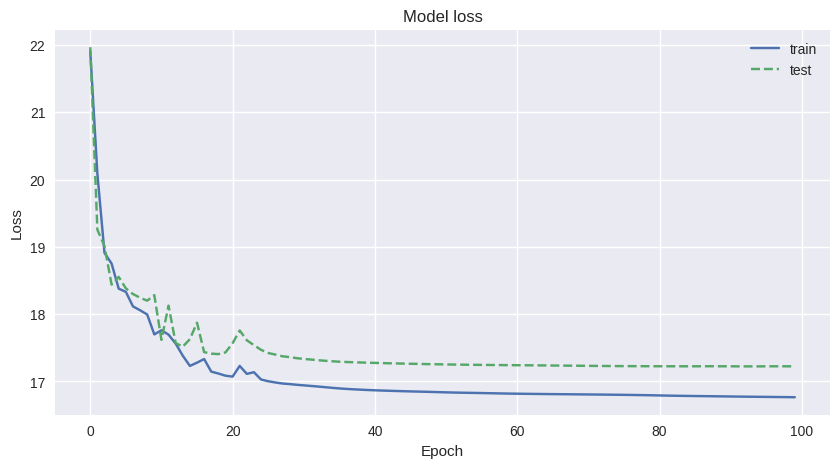

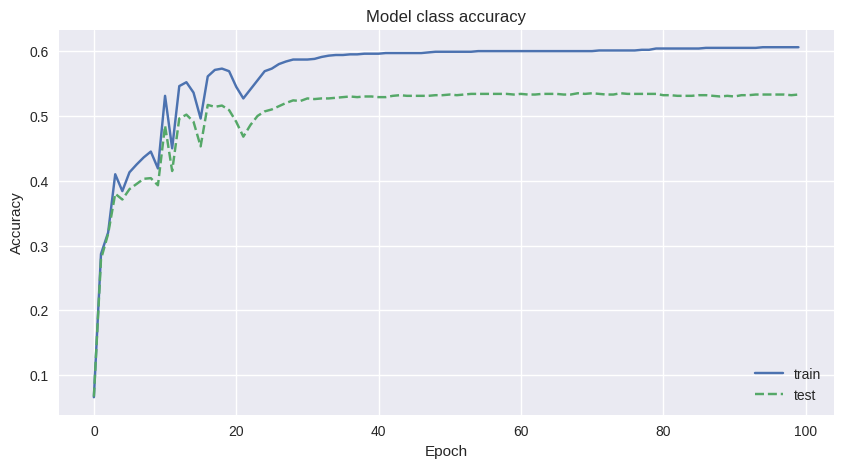

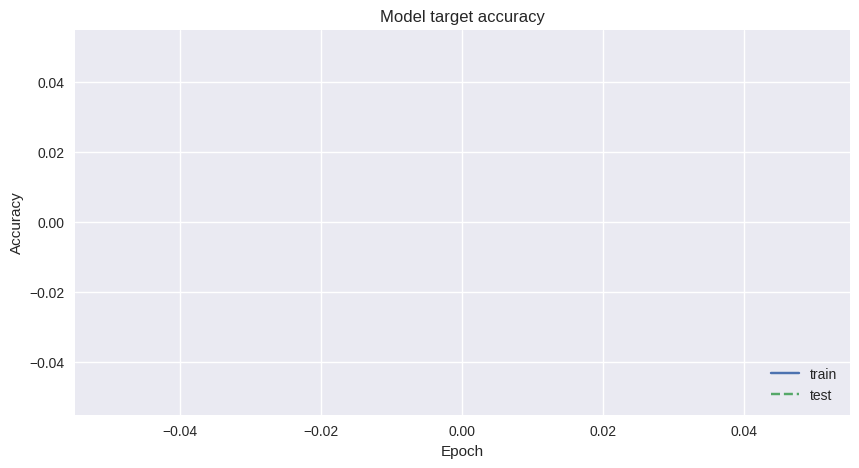

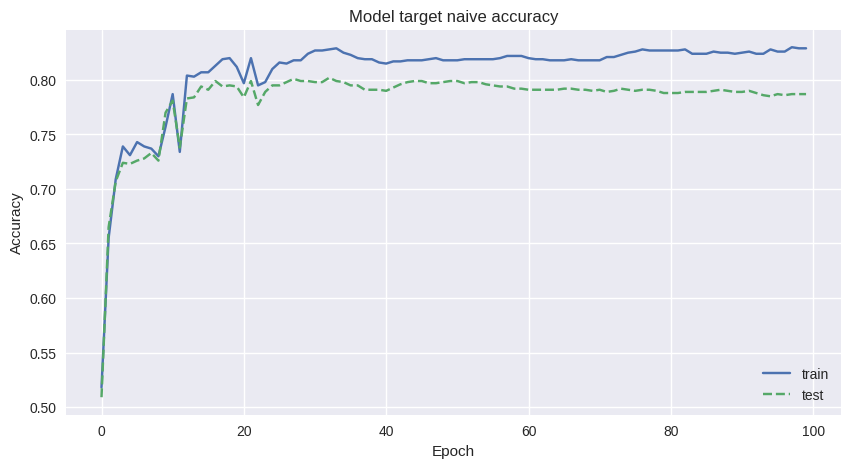

[<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>]

In [10]:
plot_info_cycle(info_cycle)


## Multiple cycle testing

In [11]:
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

params = {'model_builder': model_builder, 'model_params': model_params,
          'nb_epochs': 20, 'mini_batch_size': 100,
          'criterion_classes': nn.CrossEntropyLoss(), 'criterion_classes_params': {'input': 'pred_class{i}', 'target': 'data_classes{i}'},
          'criterion_leq': nn.BCELoss(), 'criterion_leq_params': {'input': 'pred_leq', 'target': 'data_target'},
          'optimizer_builder': torch.optim.Adam, 'optimizer_params': {},
          'weight_loss_classes': 0.0, 'weight_loss_leq': 1.0,
          'freeze_epochs': 0,
          'one_hot_classes': True, 'one_hot_leq': False,
          'unsqueeze_leq': True,
          'device': device,
          'n_cycle': 10
          }

info = evaluate_model(**params)


Cycle 1/10
Epoch 1/20 - Train loss: 0.0000
Epoch 1/20 - Test loss: 0.0000
Epoch 2/20 - Train loss: 0.0000
Epoch 2/20 - Test loss: 0.0000
Epoch 3/20 - Train loss: 0.0000
Epoch 3/20 - Test loss: 0.0000
Epoch 4/20 - Train loss: 0.0000
Epoch 4/20 - Test loss: 0.0000
Epoch 5/20 - Train loss: 0.0000
Epoch 5/20 - Test loss: 0.0000
Epoch 6/20 - Train loss: 0.0000
Epoch 6/20 - Test loss: 0.0000
Epoch 7/20 - Train loss: 0.0000
Epoch 7/20 - Test loss: 0.0000
Epoch 8/20 - Train loss: 0.0000
Epoch 8/20 - Test loss: 0.0000
Epoch 9/20 - Train loss: 0.0000
Epoch 9/20 - Test loss: 0.0000
Epoch 10/20 - Train loss: 0.0000
Epoch 10/20 - Test loss: 0.0000
Epoch 11/20 - Train loss: 0.0000
Epoch 11/20 - Test loss: 0.0000
Epoch 12/20 - Train loss: 0.0000
Epoch 12/20 - Test loss: 0.0000
Epoch 13/20 - Train loss: 0.0000
Epoch 13/20 - Test loss: 0.0000
Epoch 14/20 - Train loss: 0.0000
Epoch 14/20 - Test loss: 0.0000
Epoch 15/20 - Train loss: 0.0000
Epoch 15/20 - Test loss: 0.0000
Epoch 16/20 - Train loss: 0.0000

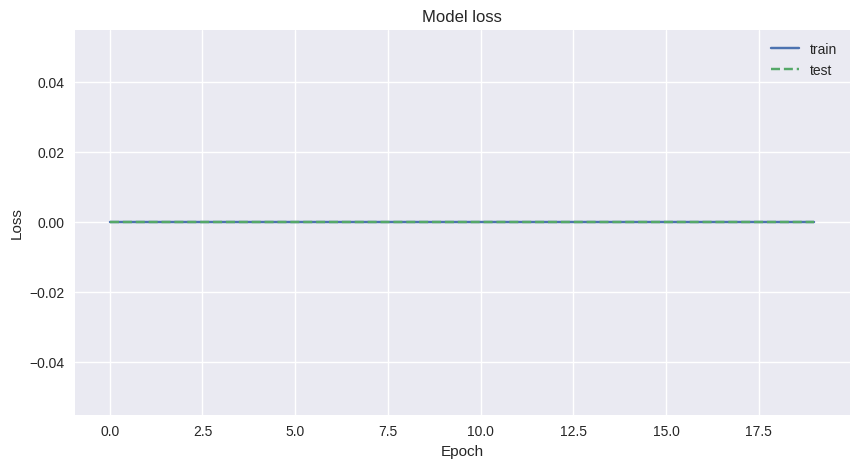

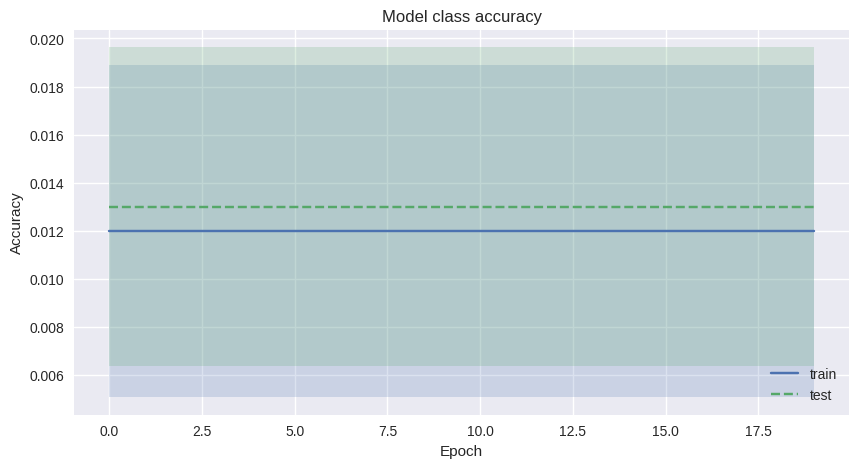

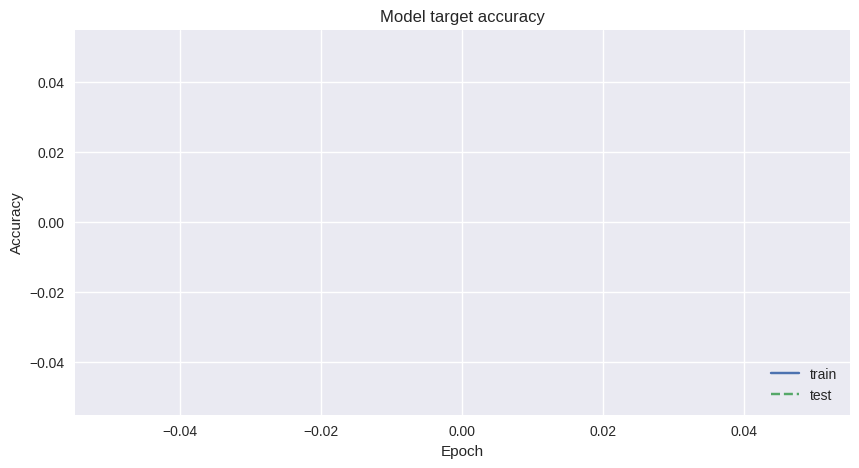

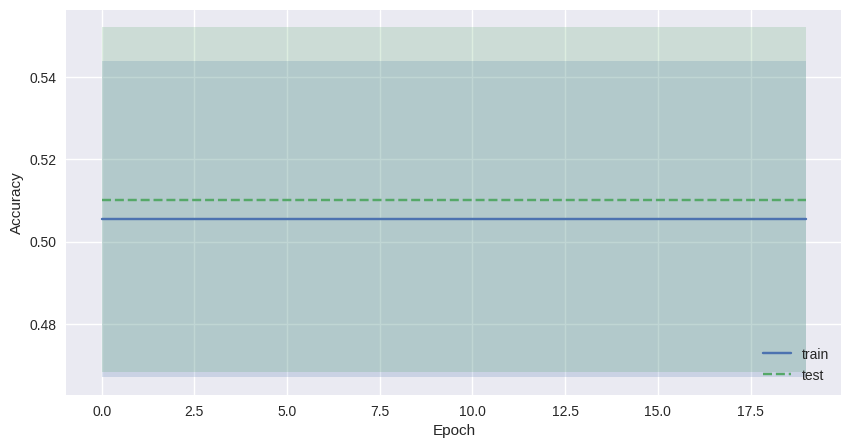

In [12]:
stats = info_stats(info)
plot_stats(stats)


# Automated grid search

In [13]:
while (out := input('Proceed with the automated search? [y/n] ')) != 'y':
    if out == 'n':
        break


## Different model types

In [14]:
MODELS = []

# SIAMESE
conv_block = {
    'dropout1': [0.0],
    'dropout2': [0.0],
    'activation1': [nn.ReLU()],
    'activation2': [nn.ReLU()],
    'use_batch_norm': [True],
    'use_skip_connections': [True],
}
conv_block_parameters_list = parameters_combinations(
    *conv_block.values(), labels=conv_block.keys())
fc_block = {
    'dropout': [0.0],
    'activation1': [nn.ReLU()],
    'activation2': [nn.ReLU()],
    'use_batch_norm': [True]
}
fc_block_parameters_list = parameters_combinations(
    *fc_block.values(), labels=fc_block.keys())
predict_list = [build_predictFC()]

model_params_list = parameters_combinations(conv_block_parameters_list, fc_block_parameters_list, predict_list,
                                            labels=['conv_block_parameters', 'fc_parameters', 'predict'])

model_dict1 = {
    'model_builder': [Siamese],
    'model_params': model_params_list,
    'one_hot_classes': [True],
    'one_hot_leq': [False],
    'unsqueeze_leq': [True],
}

# MODELS.extend(parameters_combinations_from_dict(model_dict1))

# BASELINE

model_dict2 = {
    'model_builder': [BaseLineNet],
    'model_params': [{}],
    'one_hot_classes': [True],
    'one_hot_leq': [False],
    'unsqueeze_leq': [True],
}

# MODELS.extend(parameters_combinations_from_dict(model_dict2))

# SIAMESE CONVNET 1

model_dict3 = {
    'model_builder': [SiameseConvNet1],
    'model_params': [{}],
    'one_hot_classes': [True],
    'one_hot_leq': [False],
    'unsqueeze_leq': [True],
}

MODELS.extend(parameters_combinations_from_dict(model_dict3))

# SIAMESE CONVNET 2

model_dict4 = {
    'model_builder': [SiameseConvNet2],
    'model_params': [{}],
    'one_hot_classes': [True],
    'one_hot_leq': [False],
    'unsqueeze_leq': [True],
}

MODELS.extend(parameters_combinations_from_dict(model_dict4))

# SIAMESE NN

model_dict5 = {
    'model_builder': [SiameseNN],
    'model_params': [{}],
    'one_hot_classes': [True],
    'one_hot_leq': [True],
    'unsqueeze_leq': [True],
}

MODELS.extend(parameters_combinations_from_dict(model_dict5))

# SIAMESE NN ALL

model_dict6 = {
    'model_builder': [SiameseNNAll],
    'model_params': [{}],
    'one_hot_classes': [True],
    'one_hot_leq': [True],
    'unsqueeze_leq': [True],
}

MODELS.extend(parameters_combinations_from_dict(model_dict6))

# SIAMESE 2

model_dict7 = {
    'model_builder': [Siamese2],
    'model_params': [{}],
    'one_hot_classes': [True],
    'one_hot_leq': [True],
    'unsqueeze_leq': [True],
}

MODELS.extend(parameters_combinations_from_dict(model_dict7))


In [15]:
nb_epochs_list = [25]
mini_batch_size_list = [100]

default_criterion_classes_params = {
    'input': 'pred_class{i}', 'target': 'data_classes{i}'}
criterion_classes_tuple = [
    (nn.CrossEntropyLoss(), default_criterion_classes_params)]
criterion_classes_combination = [dict(zip(['criterion_classes', 'criterion_classes_params'],
                                      criterion_classes_tuple)) for criterion_classes_tuple in criterion_classes_tuple]

default_criterion_leq_params = {'input': 'pred_leq', 'target': 'data_target'}
criterion_leq_tuples = [(nn.BCELoss(), default_criterion_leq_params)]
criterion_leq_combination = [dict(zip(['criterion_leq', 'criterion_leq_params'], criterion_leq_tuple))
                             for criterion_leq_tuple in criterion_leq_tuples]

default_optimizer_params = {}
optimizer_tuples = [(torch.optim.Adam, default_optimizer_params)]
optimizer_combination = [dict(zip(['optimizer_builder', 'optimizer_params'], optimizer_tuple))
                         for optimizer_tuple in optimizer_tuples]

weight_loss_tuples = [(0.0, 1.0), (1.0, 0.0), (0.5, 0.5)]
weight_loss_combination = [dict(zip(
    ['weight_loss_classes', 'weight_loss_leq'], wl_tuple)) for wl_tuple in weight_loss_tuples]

freeze_epochs_list = [0]

device = torch.device('cpu')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_list = [device]

n_cycle_list = [1]

TRAINING = parameters_combinations(
    nb_epochs_list,
    mini_batch_size_list,
    freeze_epochs_list,
    device_list,
    n_cycle_list,
    labels=[
        'nb_epochs',
        'mini_batch_size',
        'freeze_epochs',
        'device',
        'n_cycle'
    ]
)
TRAINING = mix_parameters_combinations(TRAINING, criterion_classes_combination,
                                       criterion_leq_combination, optimizer_combination, weight_loss_combination)


In [16]:
FINAL = mix_parameters_combinations(MODELS, TRAINING)
print(len(FINAL))


15


In [17]:
# print(len(MODELS))
# print(len(TRAINING))
# print(len(MODELS) * len(TRAINING))
# print(len(FINAL))
# print(FINAL[0])
# print(TRAINING[0])
# print(MODELS[0])
# print_parameters_combinations(TRAINING)
# print(len(parameters_combinations_from_dict(model_dict1)))
# print(len(parameters_combinations_from_dict(model_dict2)))
# print(len(parameters_combinations_from_dict(model_dict1)
#           + parameters_combinations_from_dict(model_dict2)))
# print(model_params[0])
# print(conv_block_parameters[0])


In [18]:
path = create_folder_with_datetime('Experiments')
for i, params in enumerate(FINAL):
    path_dir = os.path.join(path, params['model_builder'].__name__, str(i))
    os.makedirs(path_dir, exist_ok=True)
    export_parameters(params, os.path.join(path_dir, 'parameters.json'))

    info = evaluate_model(**params)

    stats = info_stats(info)
    export_info(info, os.path.join(path_dir, 'info.json'))
    export_info(stats, os.path.join(path_dir, 'stats.json'))
    plot_stats(stats, **SAVE_ARGS, path=path_dir)


Cycle 1/10
Epoch 1/25 - Train loss: 6.8644
Epoch 1/25 - Test loss: 6.8906
Epoch 2/25 - Train loss: 6.8598
Epoch 2/25 - Test loss: 6.8902
Epoch 3/25 - Train loss: 6.8597
Epoch 3/25 - Test loss: 6.8902
Epoch 4/25 - Train loss: 6.8597
Epoch 4/25 - Test loss: 6.8903
Epoch 5/25 - Train loss: 6.8597
Epoch 5/25 - Test loss: 6.8904
Epoch 6/25 - Train loss: 6.8597
Epoch 6/25 - Test loss: 6.8905
Epoch 7/25 - Train loss: 6.8597
Epoch 7/25 - Test loss: 6.8905
Epoch 8/25 - Train loss: 6.8597
Epoch 8/25 - Test loss: 6.8905
Epoch 9/25 - Train loss: 6.8597
Epoch 9/25 - Test loss: 6.8905
Epoch 10/25 - Train loss: 6.8597
Epoch 10/25 - Test loss: 6.8905
Epoch 11/25 - Train loss: 6.8597
Epoch 11/25 - Test loss: 6.8905
Epoch 12/25 - Train loss: 6.8597
Epoch 12/25 - Test loss: 6.8905
Epoch 13/25 - Train loss: 6.8597
Epoch 13/25 - Test loss: 6.8905
Epoch 14/25 - Train loss: 6.8597
Epoch 14/25 - Test loss: 6.8905
Epoch 15/25 - Train loss: 6.8597
Epoch 15/25 - Test loss: 6.8905
Epoch 16/25 - Train loss: 6.8597

In [19]:
# [nn.ReLU, nn.LeakyReLU, nn.Sigmoid, nn.ELU, nn.GELU]
